# Mine 5on5 Shift Data
We begin by mining all shift data from the NHL public API. Then we will filter shifts by 5on5.

In [1]:
import json
import requests
import pprint
import pandas as pd
import numpy as np
import math

### Demo for a Single Game

In [95]:
def calc_gametime_second(period, time):
    time_in_seconds = int(time[:2]) * 60 + int(time[3:])
    return (period - 1) * 1200 + time_in_seconds

##### Retrieve Data

In [43]:
# get data from api for Hurricanes vs Jets game on 07Dec2021
r = requests.get(url='https://statsapi.web.nhl.com/api/v1/teams/13/?expand=team.roster&season=20202021')
d = r.json()

In [44]:
for i in d['teams']:
    pprint.pprint(len(i['roster']['roster']))

36


In [49]:
total = 0
for i in range(0, 10):
    r = requests.get(url=f'https://api.nhle.com/stats/rest/en/shiftcharts?cayenneExp=gameId=202102039{i}')
    d = r.json()
    total += len(d['data'])
print(total/10)

754.7


In [50]:
32*82 / 2 * 754

989248.0

In [97]:
# add resolution to shift observations, track each second each shift lasted for
shift_data = []
for shift in d['data']:
    start = calc_gametime_second(shift['period'], shift['startTime']) # calculate startTime of shift
    end = calc_gametime_second(shift['period'], shift['endTime'])     # calculate endTime of shift
    seconds_on_ice = [{
        'gameId': shift['gameId'],
        'teamId': shift['teamId'],
        'playerId': shift['playerId'],
        'time': t,
        'onIce': True,
    } for t in range(start, end)] # for each second this player is on the ice, create a row
    shift_data.extend(seconds_on_ice)

##### Filter by 5on5 Shifts

In [160]:
# create dataframe object to store time on ice data
df = pd.DataFrame(shift_data)

In [161]:
# variable to help with counting the number of players on the ice
df['numPlayers'] = 1

# group players together by the time of game, sum the number of players on the ice for this second
df_strength = df[['teamId', 'time', 'numPlayers']].groupby(['time', 'teamId'], as_index=False).sum()

# convert dataframe from long to wide
df_strength = df_strength.pivot(index='time', columns='teamId', values='numPlayers')

# calculate player differential of two teams
df_strength['is_5on5'] = (df_strength[strength.columns[0]]==6) & (df_strength[strength.columns[1]]==6)

In [162]:
# # test to see if only 5on5 values are being recorded as true
# df_strength[df_strength.index.isin([*range(1260,1320)])]

# merge with original df
df = df.merge(df_strength[['is_5on5']], on='time')

# validate that our merge yields correct 5on5 time on ice...no leakage
print('Total 5on5 seconds before merge: ' + str(df_strength['is_5on5'].sum()))
print('Total 5on5 seconds after merge: ' + 
      str(df[['gameId', 'time', 'is_5on5']].groupby(['gameId', 'time']).mean()['is_5on5'].sum()))

df = df[df['is_5on5']]

Total 5on5 seconds before merge: 2717
Total 5on5 seconds after merge: 2717.0


##### Filter by Position (we only care about forwards)

In [163]:
def get_player_info(pid):
    r = requests.get(url=f'https://statsapi.web.nhl.com/api/v1/people/{pid}')
    d = r.json()
    try:
        return {
            'playerId': d['people'][0]['id'],
            'fullName': d['people'][0]['fullName'],
            'primaryPosition': d['people'][0]['primaryPosition']['code'],
            'primaryPositionType': d['people'][0]['primaryPosition']['type']
        }
    except:
        return {
            'playerId': pid,
            'fullName': '',
            'primaryPosition': '',
            'primaryPositionType': ''
        }

In [164]:
get_player_info(8471218)

{'playerId': 8471218,
 'fullName': 'Blake Wheeler',
 'primaryPosition': 'R',
 'primaryPositionType': 'Forward'}

In [123]:
# get all unique playerId
playerIds = df['playerId'].unique()

# mine position data for these players
player_info = [get_player_info(pid) for pid in playerIds]

In [165]:
# convert to df
df_players = pd.DataFrame(player_info)
df_players.head()

,playerId,fullName,primaryPosition,primaryPositionType
0,8471218,Blake Wheeler,R,Forward
1,8475799,Nino Niederreiter,R,Forward
2,8475883,Frederik Andersen,G,Goalie
3,8476460,Mark Scheifele,C,Forward
4,8476869,Brady Skjei,D,Defenseman


In [166]:
# merge with original df
df = df.merge(df_players, on='playerId')

# filter by fowards
df = df[df['primaryPositionType']=='Forward']

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

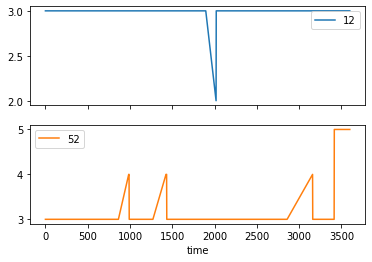

In [179]:
# validate by graphing total number of forwards on the ice for each second
## we would expect to see a constant three forwards on the ice for each team at all times
df_tmp = df[['teamId', 'time', 'numPlayers']].groupby(['time', 'teamId'], as_index=False).sum() # count fwds on ice
df_tmp = df_tmp.pivot(index='time', columns='teamId', values='numPlayers') # pivot so that teams are columns
df_tmp.plot.line(subplots=True) # plot

* For teamId 12 (Carolina Hurricanes), there is one instance of having less than 2 forwards on the ice, at t=2017 seconds. This corresponds to a penalty ending in the second period:
    * Penalty taken by Ian Cole at 11:37 of period 2
    * Penalty expires at 13:37, defenseman Ian Cole leaves the leaving the Hurricanes with 2 forwards and 3 defensemen on the ice
    * Stoppage of play at 13:39, leaving the Hurricanes to reset their lines
    
* For teamId 52 (Winnipeg Jets)
    * At t=984 (16:24 of period 1), Hurricanes penalty ends, Jets stuck with 4 forwards until change can be made
    * Happens again right before t=1500 (2 minute minor) and right after t=3000 (5 minute major)
    * At t=3415 (16:54 of period 3), Jets pull their goalie and go with 5 forwards, 1 defensman until end of game

##### Save Data

In [199]:
# drop columns that are redundant
df.drop(['onIce', 'numPlayers', 'is_5on5', 'fullName', 'primaryPosition', 'primaryPositionType'], 
        axis=1, 
        inplace=True)

In [201]:
with open('../data/shifts_forwards_5on5.csv', 'w') as f:
    df.to_csv(f)
    
with open('../data/player_info.csv', 'w') as f:
    df_players.to_csv(f)

### Automate for All Games in 2020-21 and 2021-22

In [387]:
# Set up the API call variables
shift_data = []
year = ['2020', '2021']     # 2020-2021 season and 2021-2022
season_type = '02' # 02 is regular season
max_game_ID = [869, 400]  # max number of games in season (changes depending on season)

In [388]:
# helper functions
def get_5on5_shifts(shift_data):
    # create dataframe object to store time on ice data
    df = pd.DataFrame(shift_data)

    # variable to help with counting the number of players on the ice
    df['numPlayers'] = 1

    # group players together by the time of game, sum the number of players on the ice for this second
    df_strength = df[['teamId', 'time', 'numPlayers']].groupby(['time', 'teamId'], as_index=False).sum()
    
    # for some games, data entry is messed up, recording 7 players on the ice for a team
    df_strength['numPlayers'] = np.where(df_strength['numPlayers']>=7, 6, df_strength['numPlayers'])

    # convert dataframe from long to wide
    df_strength = df_strength.pivot(index='time', columns='teamId', values='numPlayers')

    # calculate player differential of two teams
    df_strength['is_5on5'] = (df_strength[df_strength.columns[0]]==6) & (df_strength[df_strength.columns[1]]==6)
    
    # merge with original df
    df = df.merge(df_strength[['is_5on5']], on='time')

    return df[df['is_5on5']]

##### Retrieve Data and Filter by 5on5 Shifts

In [389]:
df_shifts = pd.DataFrame()

for s in range(0, len(year)):
    for gameId in range(1, max_game_ID[0]):
        # get data
        r = requests.get(url=f'https://api.nhle.com/stats/rest/en/shiftcharts?cayenneExp=gameId={year[s]}{season_type}{str(gameId).zfill(4)}')
        d = r.json()
        
        # add resolution to shift observations, track each second each shift lasted for
        shift_data = []
        for shift in d['data']:
            start = calc_gametime_second(shift['period'], shift['startTime']) # calculate startTime of shift
            end = calc_gametime_second(shift['period'], shift['endTime'])     # calculate endTime of shift
            seconds_on_ice = [{
                'gameId': shift['gameId'],
                'teamId': shift['teamId'],
                'playerId': shift['playerId'],
                'time': t,
                'onIce': True,
            } for t in range(start, end)] # for each second this player is on the ice, create a row
            shift_data.extend(seconds_on_ice)
            
        df = get_5on5_shifts(shift_data)
        df_shifts = pd.concat([df_shifts, df])
        

KeyError: "['teamId', 'time'] not in index"

In [393]:
df_shifts[df_shifts['playerId']==8471215]

,gameId,teamId,playerId,time,onIce,numPlayers,is_5on5
0,2020020001,5,8471215,35,True,1,True
12,2020020001,5,8471215,36,True,1,True
24,2020020001,5,8471215,37,True,1,True
36,2020020001,5,8471215,38,True,1,True
48,2020020001,5,8471215,39,True,1,True
...,...,...,...,...,...,...,...
20014,2020020858,5,8471215,3067,True,1,True
20026,2020020858,5,8471215,3068,True,1,True
20038,2020020858,5,8471215,3069,True,1,True
20050,2020020858,5,8471215,3070,True,1,True


##### Filter by Position (we only care about forwards)


In [ ]:
# mine position data for all unique playerIds found in df_shifts
player_info = [get_player_info(pid) for pid in df_shifts['playerId'].unique()]

In [ ]:
# convert to df
df_players = pd.DataFrame(player_info)

# merge with original df
df_shifts = df_shifts.merge(df_players, on='playerId')

# filter by fowards
df_shifts = df_shifts[df_shifts['primaryPositionType']=='Forward']

In [ ]:
# drop columns that are redundant
df_shifts.drop(['onIce', 'numPlayers', 'is_5on5', 'fullName', 'primaryPosition', 'primaryPositionType'], 
        axis=1, 
        inplace=True)

with open('../data/shifts_forwards_5on5.csv', 'w') as f:
    df_shifts.to_csv(f)
    
with open('../data/player_info.csv', 'w') as f:
    df_players.to_csv(f)

In [507]:
def get_forward_shifts(df, game_id):
    # retrieve roster for this game
    r = requests.get(url=f'https://statsapi.web.nhl.com/api/v1/game/{game_id}/boxscore')
    d = r.json()
    
    # get list of away players
    players = [{
        'playerId': val['person']['id'],
        'fullName': val['person']['fullName'],
        'primaryPosition': val['person']['primaryPosition']['code'],
        'primaryPositionType': val['person']['primaryPosition']['type']
        
    } for key, val in d['teams']['away']['players'].items()]
    
    # get list of home players, add it to list of away players
    players.extend([{
        'playerId': val['person']['id'],
        'fullName': val['person']['fullName'],
        'primaryPosition': val['person']['primaryPosition']['code'],
        'primaryPositionType': val['person']['primaryPosition']['type']
        
    } for key, val in d['teams']['home']['players'].items()])
    
    # convert to df
    df_players = pd.DataFrame(players)
    
    # merge with original df
    df = df.merge(df_players, on='playerId')

    # filter by fowards
    df = df[df['primaryPositionType']=='Forward']
    
    df.drop(['numPlayers', 'is_5on5', 'primaryPosition', 'primaryPositionType'], axis=1, inplace=True)
    
    return df

In [506]:
df_tmp = df[['teamId', 'time', 'playerId']].copy()#.groupby(['time', 'teamId'], as_index=False).sum()
df_tmp = df_tmp.sort_values(['teamId', 'time', 'playerId'])
df_tmp['playerId'] = df_tmp['playerId'].astype(str)
df_tmp
# df_tmp.pivot(index=['time'], columns='primaryPositionType')
df_tmp = df_tmp.groupby(['teamId','time'])['playerId'].apply(lambda x: '_'.join(x)).reset_index()
df_tmp['dummy'] = 1
df_tmp = df_tmp[['teamId', 'playerId', 'dummy']].groupby(['teamId', 'playerId']).sum()
df_tmp.sort_values('dummy', ascending=False)

dummy
teamId playerId                                      
12     8473533_8475855_8480830                    737
52     8477429_8477940_8479400                    619
12     8475799_8476882_8478427                    606
52     8471218_8476460_8478398                    605
12     8476389_8480039_8482093                    475
...                                               ...
52     8477940_8478424_8479400                      4
       8471669_8477940_8479400                      3
       8471669_8476460_8477429_8478398_8479400      3
12     8473533_8475799_8476882                      3
       8476389_8480039                              2

[67 rows x 1 columns]

In [516]:
df_tmp = df[['teamId', 'time', 'fullName']].copy()
df_tmp = df_tmp.sort_values(['teamId', 'time', 'fullName'])
df_tmp = df_tmp.groupby(['teamId','time'])['fullName'].apply(lambda x: '_'.join(x)).reset_index()
df_tmp['dummy'] = 1
df_tmp = df_tmp[['teamId', 'fullName', 'dummy']].groupby(['teamId', 'fullName']).sum()
df_tmp.sort_values('dummy', ascending=False).head(10)

dummy
teamId fullName                                                 
12     Andrei Svechnikov_Jesper Fast_Jordan Staal            737
52     Andrew Copp_Nikolaj Ehlers_Pierre-Luc Dubois          619
12     Nino Niederreiter_Sebastian Aho_Teuvo Teravainen      606
52     Blake Wheeler_Kyle Connor_Mark Scheifele              605
12     Martin Necas_Seth Jarvis_Vincent Trocheck             475
52     Adam Lowry_Kristian Vesalainen_Paul Stastny           415
12     Derek Stepan_Jesperi Kotkaniemi_Steven Lorentz        361
52     Dominic Toninato_Evgeny Svechnikov_Jansen Harkins     325
       Blake Wheeler_Kyle Connor_Mark Scheifele_Nikola...    116
       Evgeny Svechnikov_Kyle Connor_Mark Scheifele           81

In [470]:
# df[df['teamId']==12].sort_values(['time', 'teamId']).pivot(index='time', columns='teamId', values='playerId')
df

,gameId,teamId,playerId,time,onIce,primaryPositionType
0,2021020395,52,8471218,30,True,Forward
1,2021020395,52,8471218,31,True,Forward
2,2021020395,52,8471218,32,True,Forward
3,2021020395,52,8471218,33,True,Forward
4,2021020395,52,8471218,34,True,Forward
...,...,...,...,...,...,...
32599,2021020395,52,8478431,3178,True,Forward
32600,2021020395,52,8478431,3179,True,Forward
32601,2021020395,52,8478431,3180,True,Forward
32602,2021020395,52,8478431,3181,True,Forward


In [432]:
players

,gameId,teamId,playerId,time,onIce,numPlayers,is_5on5,fullName,primaryPosition,primaryPositionType
0,2021020395,52,8471218,30,True,1,True,Blake Wheeler,R,Forward
1,2021020395,52,8471218,31,True,1,True,Blake Wheeler,R,Forward
2,2021020395,52,8471218,32,True,1,True,Blake Wheeler,R,Forward
3,2021020395,52,8471218,33,True,1,True,Blake Wheeler,R,Forward
4,2021020395,52,8471218,34,True,1,True,Blake Wheeler,R,Forward
...,...,...,...,...,...,...,...,...,...,...
32599,2021020395,52,8478431,3178,True,1,True,Evgeny Svechnikov,L,Forward
32600,2021020395,52,8478431,3179,True,1,True,Evgeny Svechnikov,L,Forward
32601,2021020395,52,8478431,3180,True,1,True,Evgeny Svechnikov,L,Forward
32602,2021020395,52,8478431,3181,True,1,True,Evgeny Svechnikov,L,Forward


In [508]:
# df = pd.DataFrame()

# for s in range(0, len(year)):
#     for gameId in range(1, max_game_ID[0]):

# get data
game_id = '2021020395'
r = requests.get(url=f'https://api.nhle.com/stats/rest/en/shiftcharts?cayenneExp=gameId={game_id}')
d = r.json()

# add resolution to shift observations, track each second each shift lasted for
shift_data = []
for shift in d['data']:
    start = calc_gametime_second(shift['period'], shift['startTime']) # calculate startTime of shift
    end = calc_gametime_second(shift['period'], shift['endTime'])     # calculate endTime of shift
    seconds_on_ice = [{
        'gameId': shift['gameId'],
        'teamId': shift['teamId'],
        'playerId': shift['playerId'],
        'time': t,
        'onIce': True,
    } for t in range(start, end)] # for each second this player is on the ice, create a row
    shift_data.extend(seconds_on_ice)

# return 5on5 icetime
df = get_5on5_shifts(shift_data)

# filter to include forwards only
df = get_forward_shifts(df, game_id)

# group players by shift
# df = get_groups_shifts(df)
        

In [478]:
# df['primaryPositionType'].unique()